In [1]:
import anndata
import networkx as nx
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
from src.config import configure_dataset
import dill

In [2]:
dataset = "muto2021"
result_path = f"./model"

rna = anndata.read_h5ad(f"./dataset_monae/{dataset}/rna_hvg.h5ad")
atac = anndata.read_h5ad(f"./dataset_monae/{dataset}/atac_hvg.h5ad")
graph = nx.read_graphml(f"./dataset_monae/{dataset}/guidance-hvf.graphml.gz")

rna.obs['cell type'] = rna.obs['cell_type']
atac.obs['cell type'] = atac.obs['cell_type']

rna.obsm['X_pre'] = rna.X
atac.obsm['X_pre'] = atac.X

rna.X=rna.layers['counts']
atac.X=atac.layers['counts']

adatas=[rna, atac]
modal_names=["RNA", "ATAC"]
prob=['NB','NB']
rep = ['X_pre', 'X_pre']

vertices = sorted(graph.nodes)
for idx, adata in enumerate(adatas):
    configure_dataset(adata, prob[idx], 
                      use_highly_variable=True,
                      use_rep=rep[idx],
                      )

data = dict(zip(modal_names, adatas))

with open(f'{result_path}/{dataset}.dill', 'rb') as f:
    covel = dill.load(f)

In [3]:
imputation_X = covel.decode_data("RNA", "ATAC", data["RNA"], graph)
imputation = sc.AnnData(imputation_X)
print(imputation)

del data["ATAC"].obsm
raw = data["ATAC"].copy()

imputation.obs_names = data["RNA"].obs_names
imputation.obs['cell type'] = data["RNA"].obs['cell type']

del data["ATAC"]
del data["RNA"]

AnnData object with n_obs × n_vars = 19985 × 15428


In [4]:
sc.tl.pca(imputation, n_comps=10, svd_solver="auto")
sc.pp.neighbors(imputation, use_rep="X_pca", metric="cosine")
sc.tl.umap(imputation)

/home/tangzhenchao/anaconda3/envs/monae/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


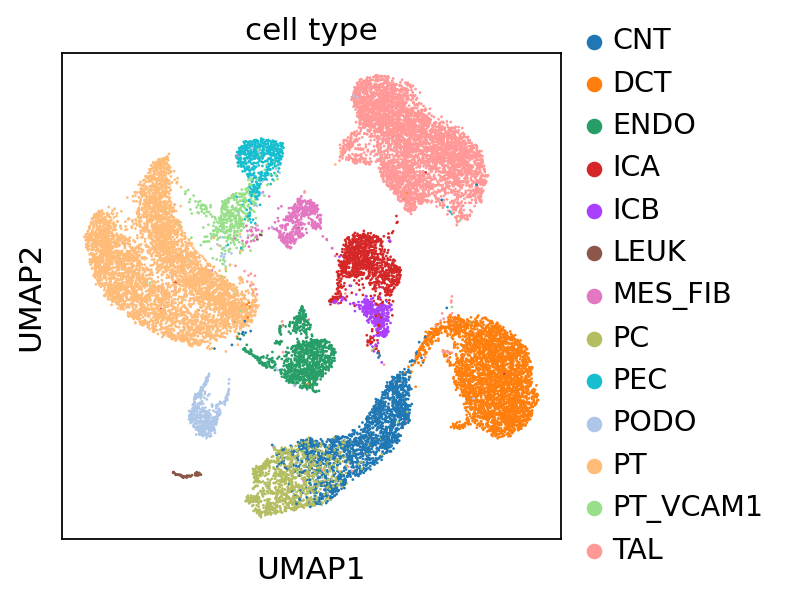

In [5]:
sc.set_figure_params(dpi=80)

sc.pl.umap(imputation, color="cell type")